<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/PSP_semantic_segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive/

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches

In [ ]:
def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

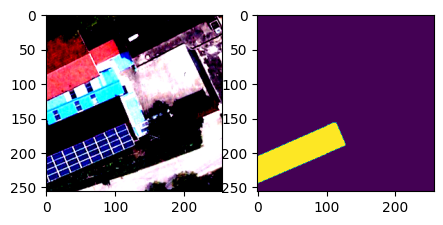

In [ ]:
img =TF.to_tensor(Image.open("processed_data/1.bmp"))
msk = TF.to_tensor(TF.to_grayscale(Image.open("processed_data/1_mask.bmp")))
plot(img,msk)

#Define the Dataset

Here I have defined a dataset class for my data.

In [ ]:
import os

class PanelImage(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.imgs = [img for img in listdir(data_path) if not img.endswith("mask.bmp")]

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.imgs[idx])
        mask_path = os.path.join(self.data_path,  f"{self.imgs[idx][:-4]}_mask.bmp")
        img = TF.to_tensor(Image.open(img_path).convert("RGB"))

        masks = Image.open(mask_path)
        masks = TF.to_tensor(TF.to_grayscale((masks)))
        boxes = masks_to_boxes(masks) if torch.nonzero(masks).size()[0]>0 else torch.Tensor([[0,0,0,0]])

        target = {}
        target["boxes"] = boxes
        target["masks"] = masks

        if self.transforms is not None:
            img = self.transforms(img)
            #target = self.transforms(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data = PanelImage("processed_data")

batch_size=20
len_train = 700
len_val= len(data) - len_train
train_set, val_set = torch.utils.data.random_split(data,[len_train, len_val])

data_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle=True, pin_memory=True)

validation_data_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,
                                          shuffle=True,pin_memory=True)

#Model Training

## Semantic Segmentation

I have found an example [here ](https://www.kaggle.com/code/balraj98/pyramid-scene-parsing-pspnet-resnext50-pytorch)and I used the config explained there.


In [ ]:
!pip install -q segmentation-models-pytorch albumentations
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00


In [ ]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["background", "panel"]
ACTIVATION = 'sigmoid'

model = smp.PSPNet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 167MB/s]


###Explore the Model

First let's try the pre-trained model as-is. I want to see the structure of its output.

In [ ]:
model.eval()

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [ ]:
test_img = data[0][0]
output = model(test_img.unsqueeze(dim=0))

In [ ]:
output.size()

torch.Size([1, 2, 256, 256])

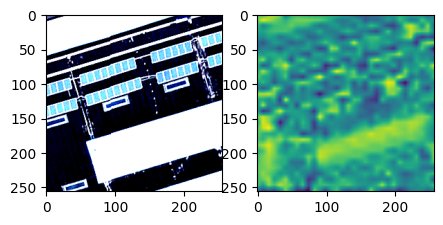

In [ ]:
plot(test_img,output[0][0])

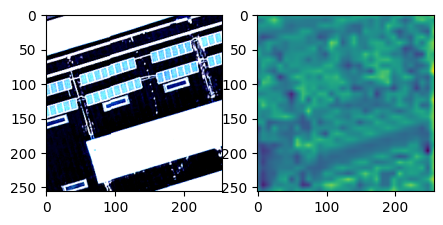

In [ ]:
plot(test_img,output[0][1])

### Train and Finetune the Model

Time to teach this model to act on our data :)

In [ ]:
lr=0.0005
epoch =40

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')#

model.to(device)
model.train()

"""loss_func = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]"""

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def dice_score(pred, target):
  return 2 * torch.sum(pred * target) / (torch.sum(pred) + torch.sum(target))

def dice_loss(pred, target):
  intersect = torch.sum(pred * target)
  union = torch.sum(pred) + torch.sum(target)
  return 1 - ((2 * intersect + 1) / (union + 1))

loss_func = dice_loss

In [ ]:
train_loss=[]
val_loss=[]
for e in range(epoch):
  dice_coef = 0
  total_loss=0
  print(f"Epoch {e} ")
  for batch, data in enumerate(data_loader):
    img = data[0].to(device)
    mask = data[1]["masks"].to(device).float()

    output = model(img)
    output = output[:,1,:,:].unsqueeze(1)
    #output = torch.nn.Sigmoid()(output)

    loss = loss_func(output, mask)
    total_loss += loss

    dice_coef += dice_score(output, mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  dice_coef/=round(len_train/batch_size)+1
  total_loss/=round(len_train/batch_size)+1
  train_loss.append(total_loss)
  print(f"train_loss: {total_loss.item():>7f}, dice_coef: {dice_coef.item():>7f}",end=" | ")

  with torch.no_grad():
    model.eval()
    epoch_val_loss = 0
    dice_coef=0

    for data in validation_data_loader:

      img = data[0].to(device)
      mask = data[1]["masks"].to(device).float()

      output = model(img)
      output = output[:,1,:,:].unsqueeze(1)
      #output = torch.nn.Sigmoid()(output)
      dice_coef += dice_score(output, mask)

      epoch_val_loss += loss_func(output, mask)

    epoch_val_loss/=round(len_val/batch_size)+1
    dice_coef/=round(len_val/batch_size)+1

    print(f"val_loss: {epoch_val_loss.item():>7f} dice_coef: {dice_coef.item():>7f}")
    print("="*50)

    val_loss.append(epoch_val_loss)
  if val_loss[-1] <= min(val_loss):
    model_state = model.state_dict()
    opt_state = optimizer.state_dict()

torch.save({'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': opt_state,
            'loss': train_loss,
          }, "saved_model/psp_seg_w.pt")

Epoch 0 
train_loss: 0.311271, dice_coef: 0.660951 | val_loss: 0.154036 dice_coef: 0.512631
Epoch 1 
train_loss: 0.234280, dice_coef: 0.737942 | val_loss: 0.148848 dice_coef: 0.517818
Epoch 2 
train_loss: 0.204514, dice_coef: 0.767708 | val_loss: 0.150578 dice_coef: 0.516088
Epoch 3 
train_loss: 0.182288, dice_coef: 0.789934 | val_loss: 0.133169 dice_coef: 0.533498
Epoch 4 
train_loss: 0.173920, dice_coef: 0.798302 | val_loss: 0.126943 dice_coef: 0.539724
Epoch 5 
train_loss: 0.171874, dice_coef: 0.800348 | val_loss: 0.126458 dice_coef: 0.540209
Epoch 6 
train_loss: 0.167300, dice_coef: 0.804922 | val_loss: 0.127445 dice_coef: 0.539221
Epoch 7 
train_loss: 0.163018, dice_coef: 0.809204 | val_loss: 0.124488 dice_coef: 0.542178
Epoch 8 
train_loss: 0.161909, dice_coef: 0.810313 | val_loss: 0.121687 dice_coef: 0.544980
Epoch 9 
train_loss: 0.152978, dice_coef: 0.819244 | val_loss: 0.114719 dice_coef: 0.551948
Epoch 10 
train_loss: 0.150933, dice_coef: 0.821289 | val_loss: 0.113318 dice_co

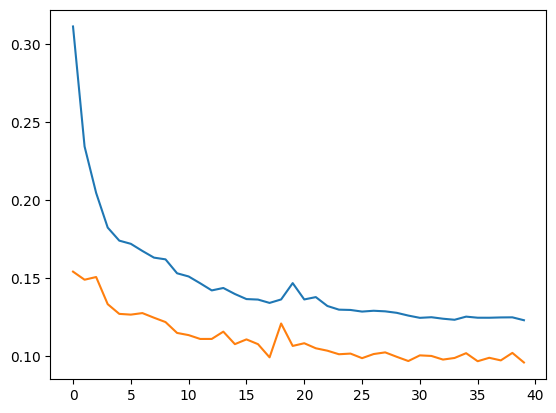

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(torch.stack(train_loss).cpu().detach().numpy(),label="train loss")
plt.plot(torch.stack(val_loss).cpu().detach().numpy(),label="validation loss")
plt.show()



---


**So, for now we can go to the Evaluation notebook and see the result there.**